# Feature Engineering

The goal here is to generate features for each match that will be generate its unique characteristics. In particular, we want to capture the meta-game (*meta*), which will mean here what the optimal strategies for a particular period of the `DotA 2` game. This will mean capturing features like drafts, items, timings, outcomes, and stuff like that. 

I could have used the hidden embeddings of project 1 below, but the above projects do not fully consider the meta.

A lot of the following will re-use code/ideas from my previous two dota projects. Please follow the undocumented projects if you are interested:
1. https://github.com/beelze-b/Open-Dota-Exploration
2. https://github.com/beelze-b/Dota-ItemSequence

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
# TURN THIS OFF IF COMING BACK FOR NEW DEVELOPMENT
import warnings
warnings.filterwarnings('ignore') 

### Remembering what is inside a match

Haven't used the Open-Dota API in a while

#### Some Immediate Features of Interest

`radiant_win` because of who wins the match, ofc. 

`draft_timings` looks good too because hero selection is very intimately tied to the meta. `picks_bans` seems to contain less information.

The statuses of the various barracks and towers look good too: does the meta prefer ratting or other methods of sieging bases in response to teamfights (or lack of)? Ratting or backdooring refers to attacking the enemy base while ignoring the enemy players or as they leave their base. Towers use 16 bit encoding. Barracks use 8 bit encoding.

The last values `radiant_gold_adv` and `radiant_xp_adv` are good too: are matches pretty close?

`duration` will be useful to see if the meta prefers short or longer games.

`radiant_score` and `dire_score` for similar reasons.

`objectives` will be useful for the roshan kill information. I am going to ignore the building information; it is most certainly useful, but I am pressed for time.

`first_blood_time` will be included. I don't think it will carry much information, but it is low hanging fruit.

###### On a deeper level, let's good at information inside `players`.

Need a function to recover approximate position (1, 2, 3, 4, 5). I am going to ignore lane swaps and the possibility for dual mid.

`hero_id` will be used.

`lane` is useful. It is important that lanes are given 1, 2, 3 going up. So Dire offlane/radiant safelane is marked as 1. Middlane is 2 for both. Radiant offlane, Dire safelane is 3.

`lane_role` will be useful to differentiate between two players in a lane. 

`total_gold` and `total_xp` will be useful.

`purchases` will be useful to notice meta items. Will need to differentiate big purchases based on some minimum cost. Will ignore upgrades to items like repeated dagon purchases. Will ignore `divine rapier`. 

Going to ignore abilities since heroes get reworked, and there is too much variety there to form a consistent set of data mining scheme. To explain: What is the difference between Invoker and Ember's W? They both might get orchid for similar reasons though, which is why I look at purchases even though there is a lot of variety there.

The following `numerical` data points will also be used:
`ancient_kills`, `neutral_kills`, `lane_kills`, `last_hits`, `denies`, `tower_damage`, `hero_damage`, `hero_healing`, `sentry_kills`, `observer_kills`, `kills`, `deaths`, `assists`, `stuns`, 
`win`, `sen_placed`, `obs_placed`, `lane_efficiency_pct`, `camps_stacked`, `buyback_count`, and `teamfight_participation` 

No `damage_taken` since it is a dictionary, and it should be reflected by the enemy team's `hero_damage`.

###### Categorical and numerical features
Some features in the above will clearly be categorical and some will be numerical. I will try to use one hot encoding for the categorical features if the algorithm desires it. Numerical features will be max-min scaled on partitioned `TI` sets.

`patch` is not GOOD: this will be a data leakage; intuitively, there should be a nearly disjoint correspondance between the meta and the patch (some patches might be similar in small aspects). We want to model characteristics inherent to the matches that tie to the overall game. The patch version, however, is  a characteristic embedded in the overall game of **DotA 2**.

## Formalizing the Above

Strategy is to identify pos 5, pos 2, pos 1, pos 3, and pos 4 in that order. Radiant and then dire. 
For each of the above, collect the above player features. In addition, collect the match features.

One hot encode all the categorical features except for tower and barracks status. Max-Min scale all the numerical features. 

Draft timings need to be encoded. Simply count the number of roshans kills. 

In [3]:

num_feat = ['ancient_kills', 'neutral_kills', 'lane_kills', 'last_hits', 'denies', 'tower_damage', 'hero_damage', 'hero_healing', 'sentry_kills', 'observer_kills', 'kills', 'deaths', 'assists', 'stuns', 
'sen_placed', 'obs_placed', 'lane_efficiency_pct', 'camps_stacked', 'buyback_count', 'teamfight_participation']

In [4]:
def parse_match(match_obj):
    features = {}
    # identify the players
    radiant_players = []
    dire_players = []
    for i in range(5):
        radiant_players.append(match_obj['players'][i])
    for i in range(5, 10):
        dire_players.append(match_obj['players'][i])
    
    dire_mid = identify_mid(dire_players)
    radiant_mid = identify_mid(radiant_players)
    dire_players.remove(dire_mid)
    radiant_players.remove(radiant_mid)
    
    dire_carry = identify_carry(dire_players)
    radiant_carry = identify_carry(radiant_players)
    dire_players.remove(dire_carry)
    radiant_players.remove(radiant_carry)
    
    dire_offlane = identify_carry(dire_players)
    radiant_offlane = identify_carry(radiant_players)
    dire_players.remove(dire_offlane)
    radiant_players.remove(radiant_offlane)
    
    dire_pos4 = identify_carry(dire_players)
    radiant_pos4 = identify_carry(radiant_players)
    dire_players.remove(dire_pos4)
    radiant_players.remove(radiant_pos4)
    
    assert len(dire_players) == 1
    assert len(radiant_players) == 1
    dire_pos5 = dire_players[0]
    radiant_pos5 = radiant_players[0]
    
    fill_in_field(features, 'hero_id', 
                  radiant_carry, radiant_mid, radiant_offlane, radiant_pos4, radiant_pos5, True)
    fill_in_field(features, 'hero_id', 
                  dire_carry, dire_mid, dire_offlane, dire_pos4, dire_pos5, False)
    
    fill_in_field(features, 'total_gold', 
                  radiant_carry, radiant_mid, radiant_offlane, radiant_pos4, radiant_pos5, True)
    fill_in_field(features, 'total_gold', 
                  dire_carry, dire_mid, dire_offlane, dire_pos4, dire_pos5, False)
    
    fill_in_field(features, 'total_xp', 
                  radiant_carry, radiant_mid, radiant_offlane, radiant_pos4, radiant_pos5, True)
    fill_in_field(features, 'total_xp', 
                  dire_carry, dire_mid, dire_offlane, dire_pos4, dire_pos5, False)
    
    for feat in num_feat:
        fill_in_field(features, feat, 
                  radiant_carry, radiant_mid, radiant_offlane, radiant_pos4, radiant_pos5, True)
        fill_in_field(features, feat, 
                  dire_carry, dire_mid, dire_offlane, dire_pos4, dire_pos5, False)
        
    features['duration'] = match_obj['duration']
    features['radiant_win'] = int(match_obj['radiant_win'])
    
    features['radiant_score'] = match_obj['radiant_score']
    features['dire_score'] = match_obj['dire_score']
    features['score_difference'] = match_obj['radiant_score'] - match_obj['dire_score']
    features['first_blood_time'] = match_obj['first_blood_time']
    try:
        features['radiant_xp_adv'] = match_obj['radiant_xp_adv'][-1]
        features['radiant_gold_adv'] = match_obj['radiant_gold_adv'][-1]
    except TypeError:
        # might be none if the information is not there
        pass
    except IndexError:
        # might be empty
        pass
        
    
    draft_timings = match['picks_bans']
    picks_radiant = []
    bans_radiant = []
    picks_dire = []
    bans_dire = []
    try:
        picks_bans = sorted(draft_timings, key = lambda x: x['order'])
    except TypeError: 
        # information might be missing
        # to much relevant info missing to exit
        return
        

    for pick_ban in picks_bans:
        active_team = pick_ban['team']
        pick_or_ban = pick_ban['is_pick']
        hero_id = pick_ban['hero_id']
        if active_team == 0:
            if pick_or_ban:
                picks_radiant.append(hero_id)
            else:
                bans_radiant.append(hero_id)
        elif active_team == 1:
            if pick_or_ban:
                picks_dire.append(hero_id)
            else:
                bans_dire.append(hero_id)
        else:
            raise Exception("Something went wrong when parsing picks and bans")
    
    for i in range(1, 6):
        features['radiant_pick_hero_id_' + str(i)] = picks_radiant[i-1]
        features['radiant_ban_hero_id_' + str(i)] = bans_radiant[i-1]
        features['dire_pick_hero_id_' + str(i)] = picks_dire[i-1]
        features['dire_ban_hero_id_' + str(i)] = bans_dire[i-1]

    return(features)
        
    
    
# find which player had highest networth but was in lane 2
def identify_mid(players_obj):
    try:
        possible_mids = filter(lambda x: x['lane_role'] == 2, players_obj)
        sorted_mids = sorted(possible_mids, key = lambda x: x['total_gold'], reverse = True)
        mid_player = sorted_mids[0]
        return mid_player
    except KeyError:
        # match did not contain the details
        sorted_mids = sorted(players_obj, key = lambda x: x['total_gold'], reverse = True)
        # pos 2 is the one with second most gold
        mid_player = sorted_mids[1]
        return mid_player

# carry can be either in safe lane or offlane
# take the one with the highest gold that isn't mid
def identify_carry(players_obj):
    return sorted(players_obj, key = lambda x: x['total_gold'], reverse = True)[0]

def fill_in_field(features_dict, field, 
                  player_pos1, player_pos2, player_pos3, player_pos4, player_pos5, isRadiant = True):
    if isRadiant:
        filler = 'radiant'
        
    else:
        filler = 'dire'
    try:
        features_dict[filler + '_carry_' + field] = player_pos1[field]
        features_dict[filler + '_mid_' + field] = player_pos2[field]
        features_dict[filler + '_off_' + field] = player_pos3[field]
        features_dict[filler + '_pos4_' + field] = player_pos4[field]
        features_dict[filler + '_pos5_' + field] = player_pos5[field]
    except KeyError:
        # this match didn't have the info
        return

In [5]:
num_features_all = ['duration', 'radiant_xp_adv', 'radiant_gold_adv', 'radiant_score', 
                    'dire_score', 'score_difference', 'first_blood_time']

In [6]:
ti5 = np.load('data/ti5_data.npy', allow_pickle = True, encoding='latin1').item()
ti6 = np.load('data/ti6_data.npy', allow_pickle = True, encoding='latin1').item()
ti7 = np.load('data/ti7_data.npy', allow_pickle = True, encoding='latin1').item()
ti8 = np.load('data/ti8_data.npy', allow_pickle = True, encoding='latin1').item()

In [7]:
ti5_matches = []
for match_id in ti5.keys():
    match = ti5[match_id]
    if match is None:
        continue
    ti5_matches.append(parse_match(match))
ti5_matches = pd.DataFrame(ti5_matches)

In [8]:
ti6_matches = []
for match_id in ti6.keys():
    match = ti6[match_id]
    if match is None:
        continue
    ti6_matches.append(parse_match(match))
ti6_matches = pd.DataFrame(ti6_matches)

In [9]:
ti7_matches = []
for match_id in ti7.keys():
    match = ti7[match_id]
    if match is None:
        continue
    ti7_matches.append(parse_match(match))
ti7_matches = pd.DataFrame(ti7_matches)

In [10]:
ti8_matches = []
for match_id in ti8.keys():
    match = ti8[match_id]
    if match is None:
        continue
    ti8_matches.append(parse_match(match))
ti8_matches = pd.DataFrame(ti8_matches)

In [11]:
mask = []
for col in ti8_matches.columns:
    mask.append(not col in ti5_matches.columns)

In [12]:
remove_col = ti8_matches.columns[mask]

In [13]:
columns_to_use = ti8_matches.columns.tolist()
for col in remove_col:
    columns_to_use.remove(col)

In [14]:
columns_to_use

['dire_ban_hero_id_1',
 'dire_ban_hero_id_2',
 'dire_ban_hero_id_3',
 'dire_ban_hero_id_4',
 'dire_ban_hero_id_5',
 'dire_carry_ancient_kills',
 'dire_carry_assists',
 'dire_carry_buyback_count',
 'dire_carry_camps_stacked',
 'dire_carry_deaths',
 'dire_carry_denies',
 'dire_carry_hero_damage',
 'dire_carry_hero_healing',
 'dire_carry_hero_id',
 'dire_carry_kills',
 'dire_carry_lane_efficiency_pct',
 'dire_carry_lane_kills',
 'dire_carry_last_hits',
 'dire_carry_neutral_kills',
 'dire_carry_obs_placed',
 'dire_carry_observer_kills',
 'dire_carry_sen_placed',
 'dire_carry_sentry_kills',
 'dire_carry_stuns',
 'dire_carry_teamfight_participation',
 'dire_carry_total_gold',
 'dire_carry_total_xp',
 'dire_carry_tower_damage',
 'dire_mid_ancient_kills',
 'dire_mid_assists',
 'dire_mid_buyback_count',
 'dire_mid_camps_stacked',
 'dire_mid_deaths',
 'dire_mid_denies',
 'dire_mid_hero_damage',
 'dire_mid_hero_healing',
 'dire_mid_hero_id',
 'dire_mid_kills',
 'dire_mid_lane_efficiency_pct',
 'd

In [15]:
# ti 5 didnt have certain matches
ti6_matches = ti6_matches[columns_to_use]
ti7_matches = ti7_matches[columns_to_use]
ti8_matches = ti8_matches[columns_to_use]

# Featurize In Preparation for Dimensionality Reduction

In [16]:
num_feat = num_feat = ['ancient_kills', 'neutral_kills', 'lane_kills', 'last_hits', 'denies', 'tower_damage', 'hero_damage', 'hero_healing', 'damage_taken', 'sentry_kills', 'observer_kills', 'kills', 'deaths', 'assists', 'stuns', 
'sen_placed', 'obs_placed', 'lane_efficiency_pct', 'camps_stacked', 'buyback_count', 'teamfight_participation', 'total_gold', 'total_xp']

In [17]:
num_features_all = ['duration', 'radiant_score', 
                    'dire_score', 'score_difference', 'first_blood_time']

In [18]:
num_feature_cols_mask = []
for col in columns_to_use:
    z = any([feat in col for feat in num_feat])
    y = any([feat in col for feat in num_features_all])
    num_feature_cols_mask.append(z or y)

In [19]:
cat_feature_cols_mask = []
for col in columns_to_use:
    z = 'hero_id' in col
    cat_feature_cols_mask.append(z)

In [20]:
num_columns = ti8_matches.columns[num_feature_cols_mask]

In [21]:
cat_columns = ti8_matches.columns[cat_feature_cols_mask]

In [22]:
leave_alone_features_mask = []

for i in range(len(columns_to_use)):
    z = not (cat_feature_cols_mask[i] | num_feature_cols_mask[i])
    leave_alone_features_mask.append(z)

In [23]:
leave_alone_columns = ti8_matches.columns[leave_alone_features_mask]

In [24]:
from sklearn import preprocessing

In [25]:
all_matches = pd.concat([ti5_matches, ti6_matches, ti7_matches, ti8_matches])

# standard scaler

scaler = preprocessing.StandardScaler()

num_transformed_df = scaler.fit_transform(all_matches[num_columns])

encoder = preprocessing.OneHotEncoder(sparse = False)

cat_transformed_df = encoder.fit_transform(all_matches[cat_columns])

trans_df = np.hstack((num_transformed_df, cat_transformed_df, all_matches[leave_alone_columns].values))
trans_df = np.nan_to_num(trans_df)

In [26]:
y  = np.hstack((5 * np.ones(ti5_matches.shape[0]), 6*np.ones(ti6_matches.shape[0]), 7*np.ones(ti7_matches.shape[0]), 
8*np.ones(ti8_matches.shape[0])))

indices_5 = y == 5
indices_6 = y == 6
indices_7 = y == 7
indices_8 = y == 8

def plot_embedding(embedding, filename):
    plt.scatter(embedding[indices_5, 0], embedding[indices_5, 1], label = "ti5")
    plt.scatter(embedding[indices_6, 0], embedding[indices_6, 1], label = "ti6")
    plt.scatter(embedding[indices_7, 0], embedding[indices_7, 1], label = "ti7")
    plt.scatter(embedding[indices_8, 0], embedding[indices_8, 1], label = "ti8")

    plt.legend()
    
    plt.savefig(filename)
    plt.show()

# UMAP

In [27]:
import umap

In [28]:
n_neighbors = 5
n_components = 2

In [29]:
embedding_umap = umap.UMAP(n_neighbors=10,
                      min_dist=0.2,
                      metric='euclidean').fit_transform(trans_df)

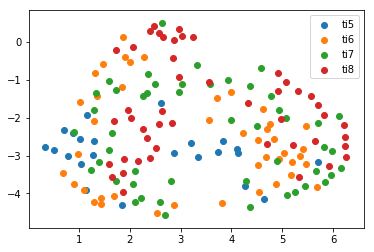

In [30]:
plot_embedding(embedding_umap, 'viz/umap.png')

# T-SNE

In [31]:
import sklearn.manifold as manifold

In [32]:
tsne_model = manifold.TSNE()
embedding_tsne = tsne_model.fit_transform(trans_df)

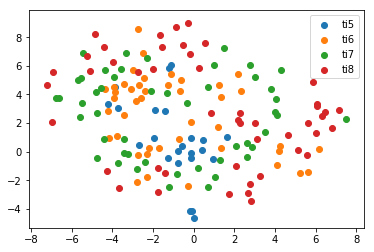

In [33]:
plot_embedding(embedding_tsne, 'viz/tsne.png')

# ISOMAP

In [34]:
isomap_model = manifold.Isomap(n_neighbors = n_neighbors, n_components = n_components)
embedding_isomap = isomap_model.fit_transform(trans_df)

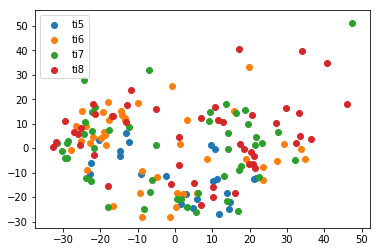

In [35]:
plot_embedding(embedding_isomap, 'viz/isomap.png')

# Locally Linear Embedding

In [36]:
lle_model = manifold.LocallyLinearEmbedding(n_neighbors = n_neighbors, n_components = n_components)
embedding_lle = lle_model.fit_transform(trans_df)

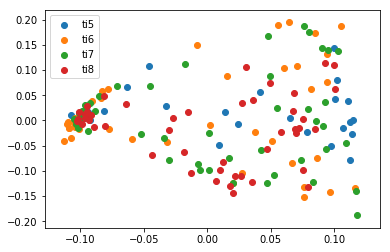

In [37]:
plot_embedding(embedding_lle, 'viz/lle.png')

# Principal Component Analysis

In [38]:
import sklearn.decomposition as decomposition

In [39]:
pca_model = decomposition.PCA(n_components = n_components)
embedding_pca = pca_model.fit_transform(trans_df)

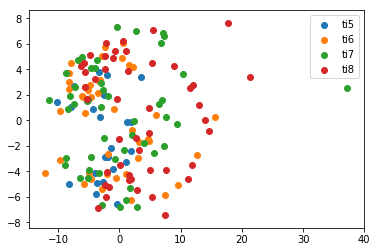

In [40]:
plot_embedding(embedding_pca, 'viz/pca.png')

# Kernel PCA

In [41]:
kpca_model = decomposition.KernelPCA(n_components=n_components, kernel = 'rbf')
embedding_kpca = kpca_model.fit_transform(trans_df)

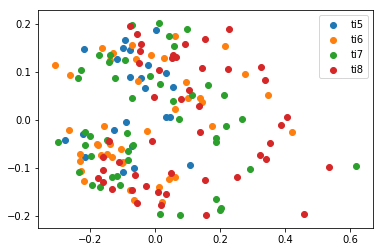

In [42]:
plot_embedding(embedding_kpca, 'viz/kpca.png')

# Fisher Discriminant Analysis

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [44]:
lda_model = LinearDiscriminantAnalysis()
embedding_lda = lda_model.fit_transform(trans_df, y)

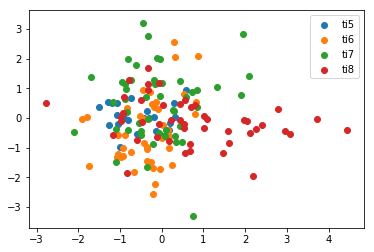

In [45]:
plot_embedding(embedding_lda, 'viz/lda.png')

# Largest Margin Nearest Neighbors

In [46]:
from metric_learn.lmnn import LMNN

In [47]:
lmnn_model = LMNN(k  = n_components, use_pca = False)
embedding_lmnn = lmnn_model.fit_transform(trans_df, y)

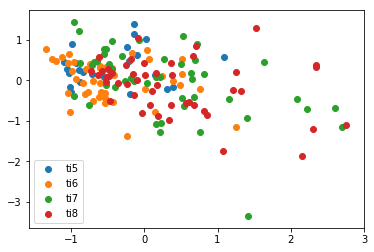

In [48]:
plot_embedding(embedding_lmnn, 'viz/lmnn.png')

# SELF

In [49]:
np.random.seed(1)

def closest_k_neighbor(x, X, K = n_neighbors):
    assert K != 1
    assert x.shape[0] == X.shape[1]
    assert K <= X.shape[0]
    distances = np.apply_along_axis(lambda y: np.sum( (x-y)**2), 1, X)
    distance_arg_sorted = np.argsort(-distances)
    index_of_k_closest = distance_arg_sorted[K-1]
    return X[index_of_k_closest, :]

def run_self(X, y, n_components, beta = 0.5):    
    assert X.shape[0] >= 100
    mask = np.zeros(X.shape[0])
    take_these_label_indices = np.random.choice(X.shape[0], size= 100, replace = False)
    mask[take_these_label_indices] = 1
    X_labeled = X[mask.astype(bool), :]
    y_labeled = y[mask.astype(bool)]
    X_all = np.vstack([X_labeled, X[~mask.astype(bool), :]])
    d = X.shape[1]
    neighbors = np.apply_along_axis(closest_k_neighbor, 1, X_labeled, X = X_all)
    sigmas = np.apply_along_axis(lambda x: np.sqrt(np.sum(x**2)), 1, X_labeled - neighbors)
    
    
    n_labeled = X_labeled.shape[0]
    n_all = X.shape[0]

    
    a_matrix = np.zeros((n_labeled, n_labeled))
    w_lb = np.zeros((n_labeled, n_labeled))
    w_lw = np.zeros((n_labeled, n_labeled))

    for ix in np.arange(n_labeled):
        for jx in np.arange(n_labeled):
            x_i = X_labeled[ix, :]
            x_j = X_labeled[jx, :]

            if (y_labeled[ix] == y_labeled[jx]):
                a_matrix[ix, jx] = np.exp(-np.sum((x_i - x_j)**2) / sigmas[ix] / sigmas[jx])
                n_y = np.sum(y_labeled == y_labeled[ix])
                w_lb[ix, jx] = a_matrix[ix, jx] * (1.0 / n_labeled - 1.0 / n_y)
                w_lw[ix, jx] = a_matrix[ix, jx] * (1.0 / n_y)
            else:
                w_lb[ix, jx] = (1.0 / n_labeled)

    Xprime = np.transpose(X_labeled)
    mu = X_all.mean(axis = 0)
    S_lb = (Xprime.dot(np.diag(w_lb.sum(axis = 0)) - w_lb)).dot(X_labeled)      
    S_lw = (Xprime.dot(np.diag(w_lw.sum(axis = 0)) - w_lw)).dot(X_labeled)  


    S_t = np.transpose(X_all).dot(X_all) - n_all * mu.reshape(-1, 1).dot(mu.reshape(1, -1))

    S_rlb = (1 - beta) * S_lb + beta * S_t
    S_rlw = (1 - beta) * S_lw + beta * np.eye(d)


    eig, vectors = scipy.linalg.eig(a = S_rlb, b = S_rlw)
    eig = np.real(eig)
    eig_sort = np.argsort(-np.abs(eig))
    eig_ind = eig_sort[:n_components]
    vectors = np.real(vectors)
    eig = np.sqrt(eig[eig_ind])
    vectors = vectors[:, eig_ind]
    T = np.zeros((d, n_components))
    for i in range(n_components):
        T[:, i] = eig[i] * vectors[:, i]
    
    return T

In [50]:
embedding_matrix = run_self(trans_df, y, n_components=n_components)

In [51]:
embedding_self = trans_df.dot(embedding_matrix)

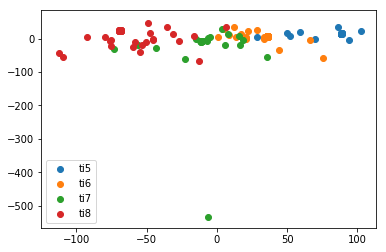

In [52]:
plot_embedding(embedding_self, 'viz/self.png')